# Import

In [1]:
%env TF_FORCE_GPU_ALLOW_GROWTH=true
%matplotlib widget 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import pickle
import spacy
import json

env: TF_FORCE_GPU_ALLOW_GROWTH=true


2023-05-20 23:42:15.992193: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-20 23:42:16.722018: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-20 23:42:16.722249: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-20 23:42:22.766949: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Récupération des données du json

## Méthode 1 : Chargement de données (lancement déconseillé car long, le corpus est déjà stocké dans un pickle plus bas)

In [ ]:
# fonction permettant de segmenter les phrases à l'aide de spacy
def make_sentences(phrases):
    nlp = spacy.load("fr_core_news_lg")
    doc = nlp(phrases)
    sentences = []
    for sent in doc.sents:
        sentences.append(sent)
    return sentences

In [ ]:
# on va chercher les données qui nous sont utiles
f = open('valid.json')
data = json.load(f)
count = 0
"""
for e in data['data'][0]['paragraphs'][0]['qas']:
    print(e)
"""    
raw_data = []

for page in data['data']: 
    for paragraphe in page['paragraphs']:
            if count < 1000 : 
                print(count)
                contexte = paragraphe['context']
                for qa in paragraphe['qas'] :
                    question = qa['question']
                    count+=1
                    for answer in qa['answers']:
                        debut_reponse = answer['answer_start']
                        # position fin de la réponse (dernier exclu)
                        fin_reponse = answer['answer_start']+len(answer['text'])
                        sentences = make_sentences(paragraphe['context'])
                        for i in range(len(sentences)) : 
                            #print("dans la phrase : "+ str(sentences[i]))
                            #print("on cherche : " + answer['text'])
                            #print("de position : " + str(debut_reponse) + "_" + str(fin_reponse))
                            if i == 0 :
                                debut_phrase = 0
                                fin_phrase = len(str(sentences[i]))    
                            else :
                                debut_phrase += len(str(sentences[i-1]))+1
                                fin_phrase += len(str(sentences[i]))+1
                            #print("debut de cette phrase : " + str(debut_phrase))
                            #print("fin de cette phrase : " + str(fin_phrase))
                            
                            # si la forme de surface est dans la phrase et que 
                            # les index de la réponse sont également compris dans la phrase
                            if answer['text'] in sentences[i].text and debut_reponse >= debut_phrase and fin_reponse <= fin_phrase :   
                                instance = {"label":"oui", "question": question, "text": sentences[i].text}
                            else :
                                instance = {"label":"non", "question": question, "text": sentences[i].text}
                            raw_data.append(instance) 
f.close()

In [ ]:
# on stocke les données dans un pickle pour ne pas avoir à les charger
with open("liste_donnees.pickle", "wb") as f:
    pickle.dump(raw_data, f)

## Méthode 2 : Récupération des données déjà chargées (méthode à privilégier)

In [2]:
raw_data = open("liste_donnees.pickle", 'rb')
raw_data = pickle.load(raw_data) 

# Modèles

In [3]:
SEQ_LEN = 50
EMB_SIZE = 2000

In [4]:
# Vocabulaire limité à 500 pour le moment
text_vectorizer = keras.layers.TextVectorization(
        max_tokens=EMB_SIZE,
        standardize='lower_and_strip_punctuation',
        split="whitespace",
        output_mode="count")
normalizer = keras.layers.Normalization()

2023-05-20 23:42:38.929671: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1) Modèle binaire

In [ ]:
def PerceptronModel():
    inputs1 = keras.layers.Input(shape=(text_vectorizer.vocabulary_size(),), name="entrée1")
    inputs2 = keras.layers.Input(shape=(text_vectorizer.vocabulary_size(),), name="entrée2")
    addition = keras.layers.Add()([inputs1, inputs2])
    #coucheDense1 = keras.layers.Dense(32, activation="relu")(addition)
    #coucheDrop = keras.layers.Dropout(0.5)(coucheDense1)
    #neuron = keras.layers.Dense(1, activation="sigmoid", use_bias=True, name="coucheactivation")(coucheDrop)
    neuron = keras.layers.Dense(1, activation="sigmoid", use_bias=True, name="coucheactivation")(addition)
    model = keras.Model(inputs=(inputs1, inputs2), outputs=neuron)
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=["accuracy"])
    return model

## 2) Modèle Sparse Categorical avec count

In [5]:
def PerceptronModelSparseCategorical():
    inputs1 = keras.layers.Input(shape=(text_vectorizer.vocabulary_size(),), name="entrée1")
    inputs2 = keras.layers.Input(shape=(text_vectorizer.vocabulary_size(),), name="entrée2")
    #norm1 = normalizer(inputs1)
    #norm2 = normalizer(inputs2)
    #addition = keras.layers.Add()([norm1, norm2])
    addition = keras.layers.Add()([inputs1, inputs2])
    neuron = keras.layers.Dense(len(cat), activation="softmax", use_bias=True, name="couche1")(addition)
    model = keras.Model(inputs=(inputs1, inputs2), outputs=neuron)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])
    return model

## 3) Modèle Sparse Categorical avec int (non fonctionnel, à ne pas tester pour ne pas écraser le textvectoriser et le modèle précédent)

In [ ]:
# text_vectorizer avec int ne fonctionnant pas
text_vectorizer = keras.layers.TextVectorization(max_tokens=EMB_SIZE,
                                    output_sequence_length=SEQ_LEN,
                                    #standardize='lower_and_strip_punctuation',
                                    standardize=None,
                                    split='whitespace',
                                    output_mode='int')
normalizer = keras.layers.Normalization()

In [ ]:
def PerceptronModelSparseCategorical():
    inputs1 = keras.layers.Input(shape=(SEQ_LEN,), name="entrée1")
    inputs2 = keras.layers.Input(shape=(SEQ_LEN,), name="entrée2")
    norm1 = normalizer(inputs1)
    norm2 = normalizer(inputs2)
    #addition = keras.layers.Add()([norm1, norm2])
    addition = keras.layers.Add()([inputs1, inputs2])
    #embeddings = keras.layers.Embedding(text_vectorizer.vocabulary_size(), 100, mask_zero=True, name="emb")(addition)
    #embeddings = keras.layers.Embedding(text_vectorizer.vocabulary_size(), 32, name="emb")(addition)
    #pooling = keras.layers.GlobalMaxPooling1D()(embeddings)
    #pooling = keras.layers.Dropout(rate=0.6)(pooling)
    #neuron = keras.layers.Dense(len(cat), activation="softmax", use_bias=True, name="couche1")(pooling)
    embeddings = keras.layers.Embedding(input_dim=text_vectorizer.vocabulary_size(), output_dim=SEQ_LEN, name="emb")(addition)
    neuron = keras.layers.Dense(len(cat), activation="softmax", use_bias=True, name="couche1")(embeddings)
    model = keras.Model(inputs=(inputs1, inputs2), outputs=neuron)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])
    return model

## 4) Tuner

In [20]:
from keras_tuner import HyperParameters, RandomSearch, BayesianOptimization, GridSearch
from keras.optimizers import Adam, SGD

In [26]:
def build_model(tv: keras.layers.TextVectorization,
                nb_classes,
                lr,
                pooling_strategy,
                emb_size=EMB_SIZE,
                ):
    inputs1 = keras.layers.Input(shape=(text_vectorizer.vocabulary_size(),), name="entrée1")
    inputs2 = keras.layers.Input(shape=(text_vectorizer.vocabulary_size(),), name="entrée2")
    #norm1 = normalizer(inputs1)
    #norm2 = normalizer(inputs2)
    addition = keras.layers.Add()([inputs1, inputs2])
    #addition = keras.layers.Add()([norm1, norm2])
    
    #embeddings = keras.layers.Embedding(text_vectorizer.vocabulary_size(), 100, name="emb")(addition)
    #pooling = keras.layers.GlobalMaxPooling1D()(embeddings)
    #pooling = keras.layers.Dropout(rate=0.5)(pooling)
    
    neuron = keras.layers.Dense(nb_classes, activation="softmax", use_bias=True, name="couche1")(addition)
    model = keras.Model(inputs=(inputs1, inputs2), outputs=neuron)
    model.compile(optimizer=Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=["accuracy"])
    return model

# on crée l'hypermodèle qui va retourner un lr selon les modalités données
def hypermodel(hp: HyperParameters)-> keras.Model:
    #lr = hp.Float("lr", min_value=0.0001,
    #              max_value=0.1,
    #              step=5,
    #              sampling='log')
    emb_size = hp.Int("emb_size", min_value=1800,
                  max_value=2200,
                  step=200,
                  sampling='linear')
    return build_model(text_vectorizer, 2, lr=0.0001, pooling_strategy="max", emb_size = emb_size )

In [27]:
# le tuner qui va prendre l'hypermodèle, l'objectif, le max d'essais et l'endroit
# où on va stocker le projet (à changer à chaque nouvelle config)
tuner = RandomSearch(
    hypermodel=hypermodel,
    objective="val_accuracy",
    max_trials=3, project_name="nouveau_random_emb_size"
)

# Préparation des données pour l'entraînement

In [6]:
# fonction permettant d'extraire un sous corpus plus petit
def mini_raw_data(nb, raw_data):
    mini_raw = []
    count = 0
    for e in raw_data:
        if count < nb :
            mini_raw.append(e)
            count+=1
    return mini_raw

In [ ]:
#text_vectorizer.adapt([x['question'] for x in raw_data])
#text_vectorizer.adapt([x['text'] for x in raw_data])

In [7]:
liste = []
for x in raw_data :
    liste.append(x['question'])
    liste.append(x['text'])

In [8]:
text_vectorizer.adapt(liste)

In [9]:
text_vectorizer.vocabulary_size()

2000

In [10]:
#raw_data = mini_raw_data(118, raw_data)
training_data = np.array([[text_vectorizer(d['question']), text_vectorizer(d['text'])] for d in raw_data])
cat = list(sorted(set(d['label'] for d in raw_data)))
cat_to_int = {l: i for i,l in enumerate(cat)}
labels = np.array([cat_to_int[d['label']] for d in raw_data])

In [11]:
X_traindev, X_test, Y_traindev, Y_test = train_test_split(training_data, labels, train_size=0.8, shuffle=False)
X_train, X_dev, Y_train, Y_dev = train_test_split(X_traindev, Y_traindev, train_size=0.8, shuffle=False)

In [12]:
np.shape(training_data)

(6631, 2, 2000)

In [13]:
# fonction permettant de séparer les questions d'un côté et les phrases de l'autre, pour le passer au modèle
def separation(donnes_a_sep):
    questions = []
    phrases = []
    for couple in donnes_a_sep:
        questions.append(couple[0])
        phrases.append(couple[1])
    questions = np.array(questions)
    phrases = np.array(phrases)
    return questions, phrases
questions_train, phrases_train = separation(X_train)
questions_dev, phrases_dev = separation(X_dev)
questions_test, phrases_test = separation(X_test)

# Entrainement

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 entrée1 (InputLayer)           [(None, 2000)]       0           []                               
                                                                                                  
 entrée2 (InputLayer)           [(None, 2000)]       0           []                               
                                                                                                  
 add (Add)                      (None, 2000)         0           ['entrée1[0][0]',                
                                                                  'entrée2[0][0]']                
                                                                                                  
 couche1 (Dense)                (None, 2)            4002        ['add[0][0]']                

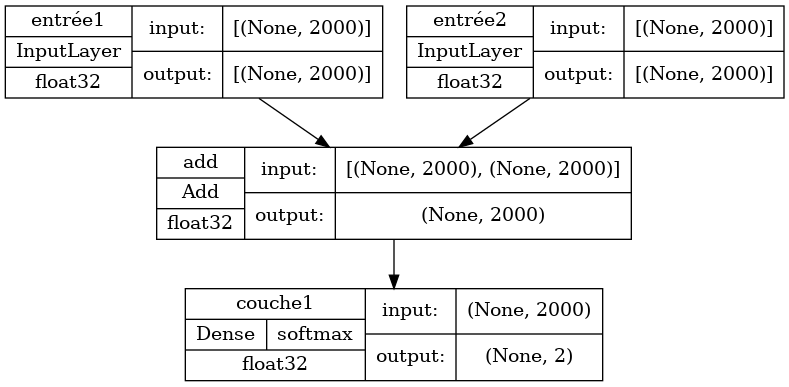

In [14]:
# modèle à décommenter si on est en sparse categorical crossentropy
m = PerceptronModelSparseCategorical()
# modèle à décommenter si on est en binary crossentropy
#m = PerceptronModel()
m.summary()
keras.utils.plot_model(m,show_dtype=True, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [15]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [16]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min',save_best_only=True)

In [17]:
training_log = m.fit(x=(questions_train, phrases_train), y=Y_train, epochs=500, batch_size=128, validation_data=((questions_dev, phrases_dev), Y_dev), verbose=0,callbacks=[mc, es])
#training_log = m.fit(x=(X_train[:,0,:], X_train[:,1,:]), y=Y_train, epochs=100, batch_size=512, validation_data=((X_dev[:,0,:], X_dev[:,1,:]), Y_dev), verbose=0)

Epoch 119: early stopping


In [18]:
print('validation accuracy', training_log.history['val_accuracy'][-1])

validation accuracy 0.8030160069465637


# Visualisation

42/42 [==============================] - 1s 3ms/step


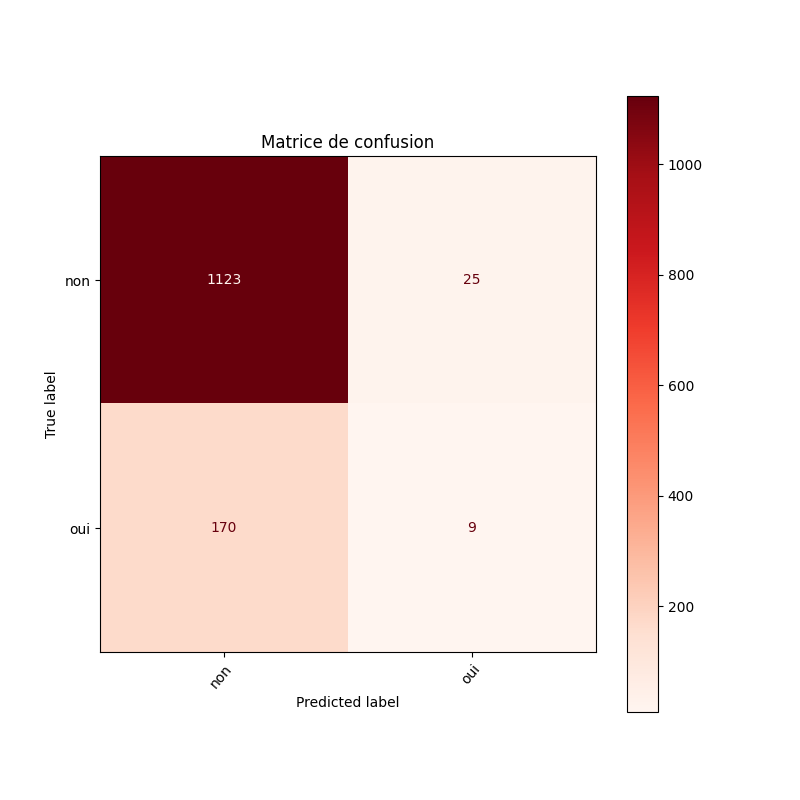

In [19]:
plt.close()
Y_output = m.predict([questions_test, phrases_test])
#prédiction a décommenter si on est en sparse categorical crossentropy
Y_prediction = np.argmax(Y_output, axis=1)
#prédiction à décommenter si on est en binary crossentropy
#Y_prediction = [1 * (x[0]>=0.50) for x in Y_output]
cm = confusion_matrix(Y_test, Y_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cat)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap=plt.cm.Reds)
plt.setp(ax.get_xticklabels(), rotation=50, ha="right", rotation_mode="anchor")
ax.set_title("Matrice de confusion")
plt.show()

# Lancement tuner

In [28]:
tuner.search_space_summary()

Search space summary
Default search space size: 1
emb_size (Int)
{'default': None, 'conditions': [], 'min_value': 1800, 'max_value': 2200, 'step': 200, 'sampling': 'linear'}


In [ ]:
tuner.search((questions_train, phrases_train), Y_train, epochs=200, validation_data=((questions_dev, phrases_dev), Y_dev), verbose=1)

In [ ]:
tuner.results_summary()